In [1]:
import dir_constants as dc
from tqdm import tqdm
from j_utils import munging as mg
from j_utils import eval_results as er
from fastai.structured import *

pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999
pd.options.display.max_seq_items = None
# np.set_printoptions(threshold=100)

In [2]:
PATH = dc.data_path
project = 'lendingclub'
fname_base_loan = 'base_loan_info.fth'
fname_eval_loan = 'eval_loan_info.fth'
fname_str_loan = 'str_loan_info.fth'
fname_scl_pmt = 'scaled_pmt_hist.fth'
data_path = f'{PATH}{project}'

In [3]:
# load in and drop fico low
base_loan_info = pd.read_feather(f'{data_path}/base_loan_info.fth')
base_loan_info.drop('fico_range_low', axis=1, inplace=True)
eval_loan_info = pd.read_feather(f'{data_path}/eval_loan_info.fth')
str_loan_info = pd.read_feather(f'{data_path}/str_loan_info.fth')

In [4]:
## load in pmt_hist and fix target_strict
# scaled_pmt_hist = pd.read_feather(f'{data_path}/scaled_pmt_hist.fth')
# bad_statuses = set(['late_120', 'defaulted', 'charged_off', 'late_30'])
# target_strict_dict = {}
# id_grouped = scaled_pmt_hist.groupby('id')
# for ids, group in tqdm(id_grouped):
#     statuses = set(group['status_period_end'])
#     if len(statuses.intersection(bad_statuses)) > 0:
#         target_strict_dict[ids] = 1
#     else:
#         target_strict_dict[ids] = 0
# target_strict = pd.DataFrame.from_dict(target_strict_dict, orient='index').reset_index(drop=False)
# target_strict.columns = ['id', 'target_strict']
# eval_loan_info.drop('target_strict', axis=1, inplace=True)
# eval_loan_info = pd.merge(eval_loan_info, target_strict, how='outer', on='id')
# eval_loan_info['target_strict'] = eval_loan_info['target_strict'].fillna(0).astype(int)
# eval_loan_info.to_feather(f'{data_path}/eval_loan_info.fth')

In [5]:
to_delete = ['fico_range_low']
cat_shap_30 = ['sub_grade', 'term', 'annual_inc', 'acc_open_past_24_mths', 'loan_amount', 'dti', 'fico_range_high', 'id', 'grade', 'total_bc_limit', 'mo_sin_old_rev_tl_op', 'home_ownership', 'percent_bc_gt_75', 'mort_acc', 'int_rate', 'addr_state', 'mths_since_recent_bc', 'revol_util', 'delinq_2_yrs', 'inq_last_6_mths', 'installment', 'addr_zip', 'bc_util', 'total_il_high_credit_limit', 'emp_length', 'revol_bal', 'purpose', 'num_rev_tl_bal_gt_0', 'earliest_cr_lineElapsed', 'tot_hi_cred_lim']

lgbm_shap_30 = ['sub_grade', 'term', 'addr_zip', 'grade', 'acc_open_past_24_mths', 'dti', 'annual_inc', 'loan_amount', 'id', 'fico_range_high', 'home_ownership', 'mort_acc', 'total_bc_limit', 'emp_length', 'delinq_2_yrs', 'mo_sin_old_rev_tl_op', 'mths_since_recent_bc', 'bc_open_to_buy', 'avg_cur_bal', 'inq_last_6_mths', 'int_rate', 'mo_sin_rcnt_tl', 'installment', 'percent_bc_gt_75', 'revol_util', 'num_rev_tl_bal_gt_0', 'total_il_high_credit_limit', 'purpose', 'revol_bal', 'total_acc']

In [6]:
shap_30_ft = np.array(sorted(list(set(cat_shap_30).union(set(lgbm_shap_30)))))
print(len(shap_30_ft))

34


In [7]:
np.array(sorted(list(set(cat_shap_30).union(set(lgbm_shap_30)))))

array(['acc_open_past_24_mths', 'addr_state', 'addr_zip', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy',
       'bc_util', 'delinq_2_yrs', 'dti', 'earliest_cr_lineElapsed', 'emp_length', 'fico_range_high', 'grade',
       'home_ownership', 'id', 'inq_last_6_mths', 'installment', 'int_rate', 'loan_amount',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_rev_tl_bal_gt_0',
       'percent_bc_gt_75', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'tot_hi_cred_lim',
       'total_acc', 'total_bc_limit', 'total_il_high_credit_limit'],
      dtype='<U26')

shap_30_ft definitions, bank cards are atm/debit cards

acc_open_past_24_mths = number of accounts opened in 24 mths
addr_state = borrower's state
addr_zip = borrower's zip
annual_inc = self-reported annual income by borrower
avg_cur_bal = average current balance on all accounts
bc_open_to_buy = total open to buy on revolving bankcards (total remaining available credit on bankcards)
bc_util = bankcard utilization in percent
delinq_2_yrs = The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
dti = A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income
earliest_cr_lineElapsed = a date of earliest credit line converted to epoch time?
emp_length = Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years
fico_range_high = credit score upper bound (of only 4 diff to lower bound)
grade = LC's grade
home_ownership = The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
id = A unique LC assigned ID for the loan listing
inq_last_6_mths = The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
installment = monthly payment owed by borrower if loan originates
int_rate = loan's interest rate
loan_amount = loan amount
mo_sin_old_rev_tl_op = Months since oldest revolving account opened
mo_sin_rcnt_tl = Months since most recent account opened
mort_acc = Number of mortgage accounts
mths_since_recent_bc = Months since most recent bankcard account opened
num_rev_tl_bal_gt_0 = Number of revolving trades with balance >0
percent_bc_gt_75 = Percentage of all bankcard accounts > 75% of limit
purpose = A category provided by the borrower for the loan request
revol_bal = Total revolving credit balance
revol_util = amount of credit borrower using relative to avail revolving credit
sub_grade = LC subgrade
term = loan term
tot_hi_cred_lim = Total high credit/credit limit
total_acc = The total number of credit lines currently in the borrower's credit file
total_bc_limit = Total bankcard high credit/credit limit
total_il_high_credit_limit = Total installment high credit/credit limit

new features to try:
ratios of income/installment to high limits.

In [8]:
def transform_dates(df):
    '''
    Looks for datetime columns in the df, uses fastai's add_datepart to turn it
    into several columns (year, day, is quarter end, etc.)
    Does this inplace.
    '''
    date_cols = list(df.select_dtypes('datetime').columns)
    for col in date_cols:
        add_datepart(df, col,)

In [9]:
transform_dates(base_loan_info)

In [11]:
# converted features
base_loan_info['dti'] = base_loan_info['dti']/100

In [44]:
# added features
base_loan_info['monthly_inc'] = base_loan_info['annual_inc']/12
base_loan_info['dti_w_loan'] = np.minimum(99999,(base_loan_info['dti']*base_loan_info['monthly_inc']+base_loan_info['installment'])/base_loan_info['monthly_inc'])
base_loan_info['delinq_to_monthly_inc'] = np.minimum(99999,base_loan_info['delinq_amnt']/base_loan_info['monthly_inc'])
base_loan_info['tot_cur_bal_to_monthly_inc'] = np.minimum(99999,base_loan_info['tot_cur_bal']/base_loan_info['monthly_inc'])

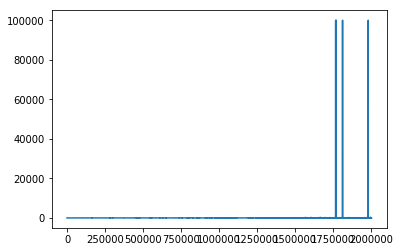

In [45]:
base_loan_info['dti_w_loan'].plot()
plt.show()

In [46]:
base_loan_info['dti_w_loan'].describe()

count    2.002748e+06
mean     4.692211e-01
std      1.413237e+02
min      1.648147e-04
25%      1.843796e-01
50%      2.558844e-01
75%      3.347594e-01
max      9.999900e+04
Name: dti_w_loan, dtype: float64